### TYK2 IL-23 RNA-seq

1. [Dataset Properties](#part1)
2. [Unsupervised Profiles](#part2)
3. [Statisticla Modeling](#part3)
4. [Differentially Expressed Genes](#part4)
5. [Gene Visualizations](#part5)

In [2]:
library(ggpubr)
library(DESeq2)
library(ggcorrplot)
library(furrr)
library(ggbiplot)
library(patchwork)
library(ComplexHeatmap)
library(tidyverse)

#### Dataset Properties <a name="part1"></a>

In [3]:
alignments <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_star.txt") %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

count_summary <- read_tsv("../pipeline/diffexp/multiqc_data/multiqc_featureCounts.txt")  %>%
    mutate(id = as.numeric(gsub("_.*", "", Sample)))

Rows: 80 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (26): insertion_length, unmapped_other, multimapped_toomany_percent, unm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 80 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Sample
dbl (16): Unassigned_Chimera, Unassigned_Duplicate, Unassigned_NoFeatures, U...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


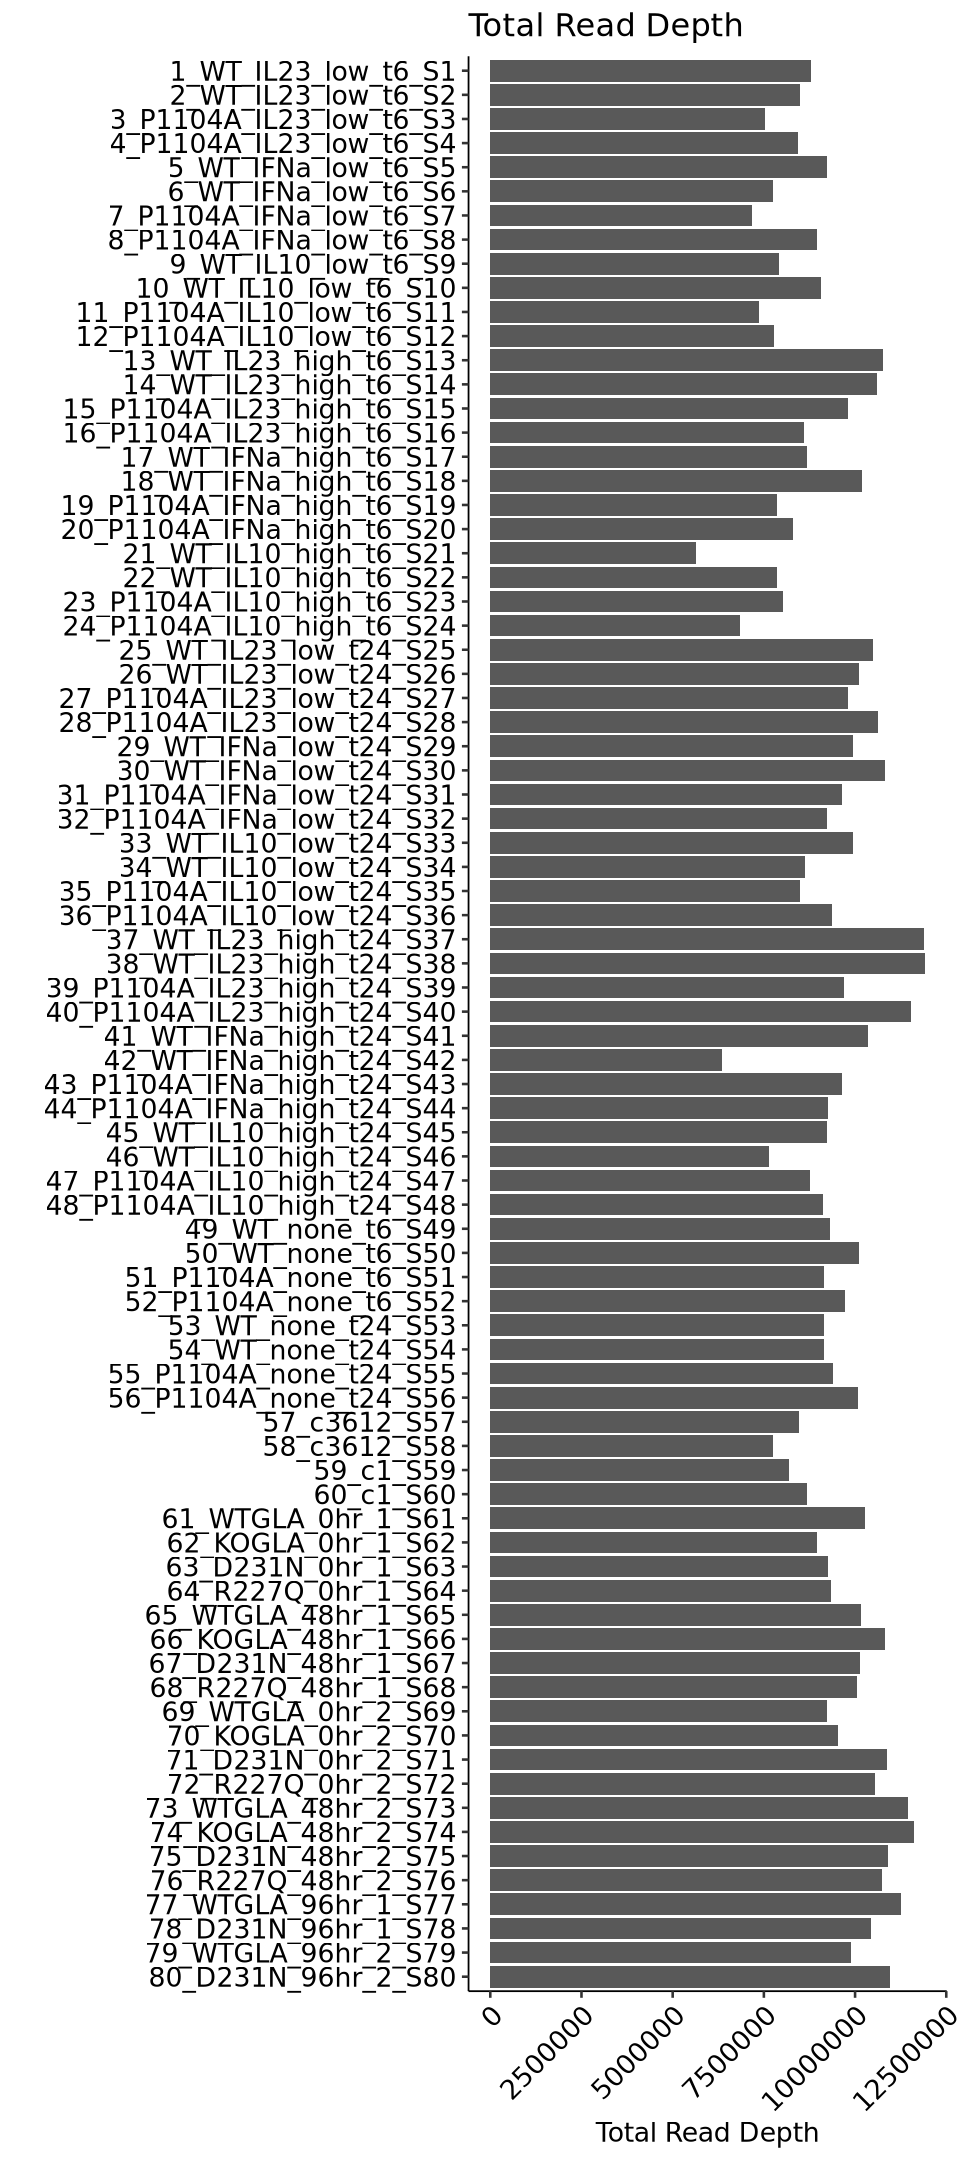

In [4]:
options(repr.plot.width = 8, repr.plot.height = 18)
alignments %>%
    ggplot() +
        geom_bar(aes(x = total_reads, y = reorder(Sample, -id)), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Total Read Depth") + ylab("") +
        ggtitle("Total Read Depth")

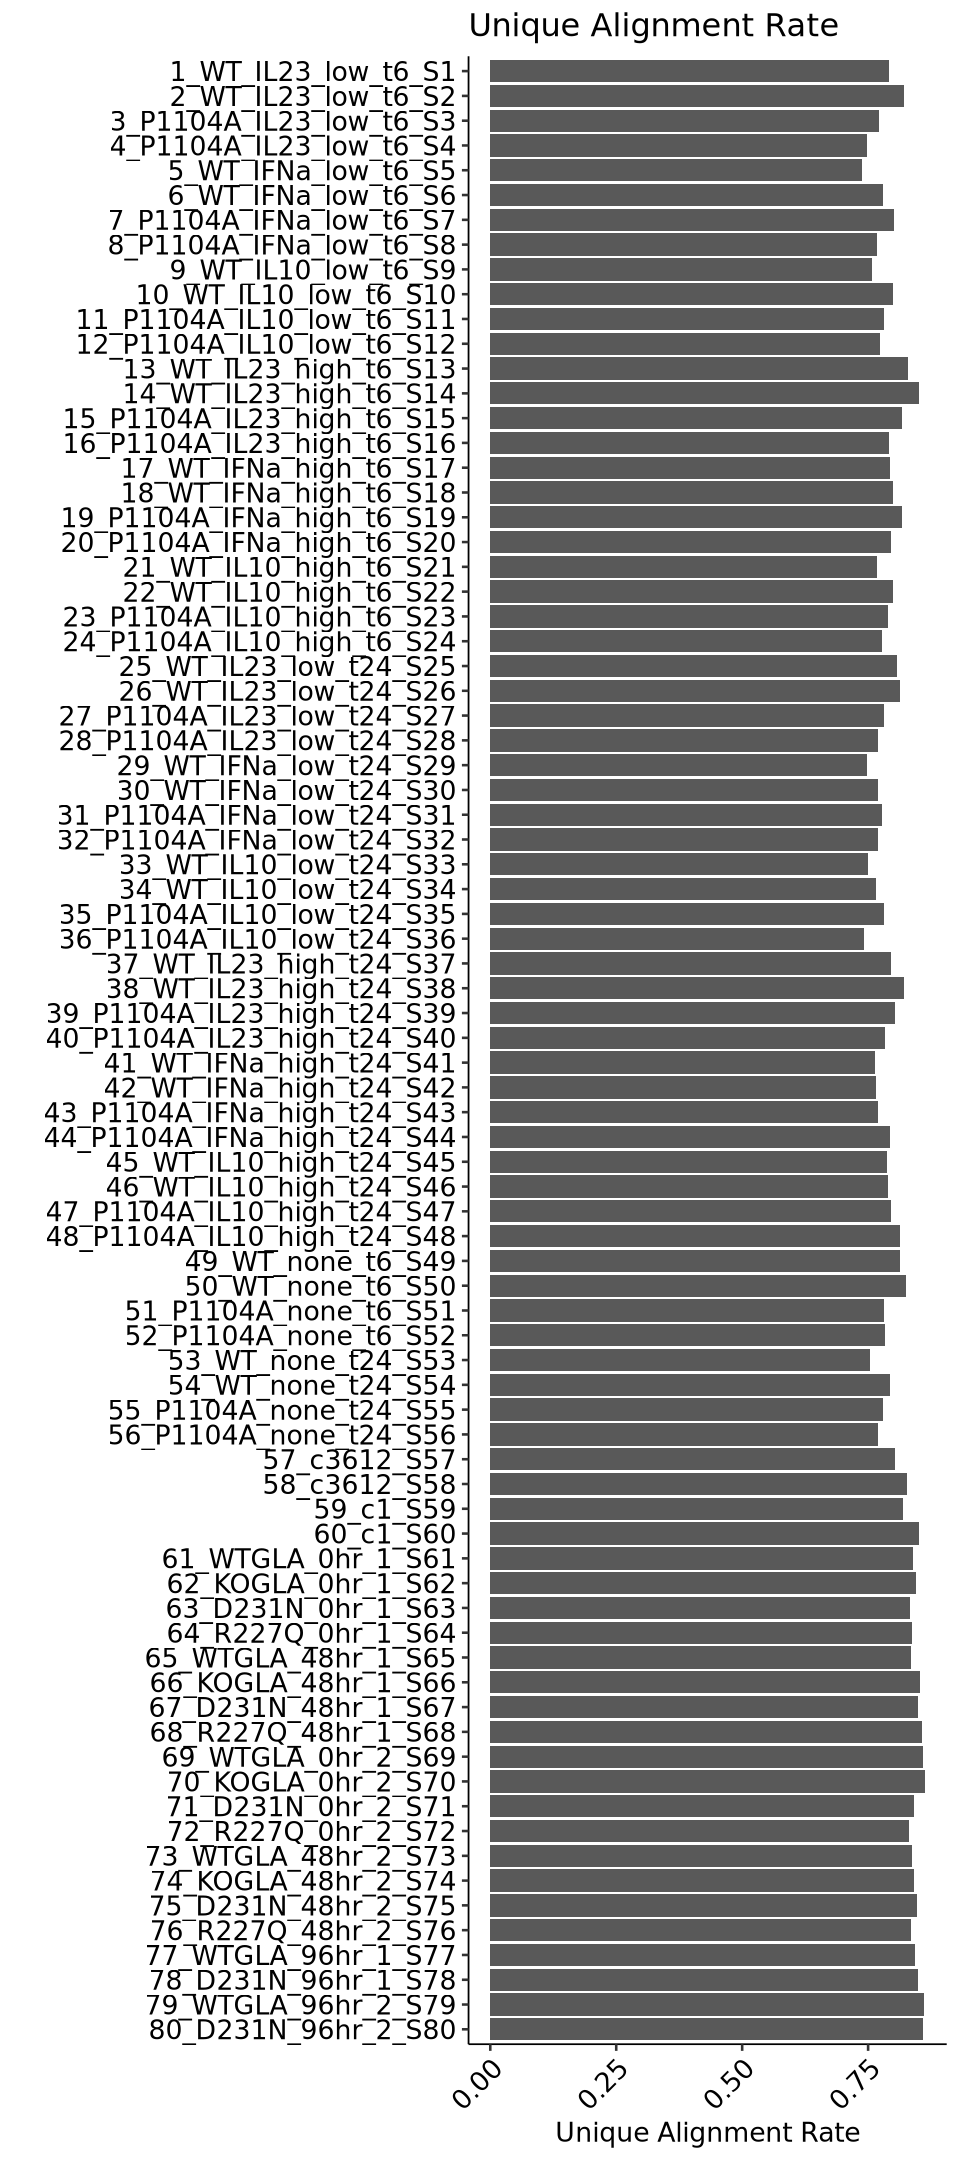

In [5]:
alignments %>%
    ggplot() +
        geom_bar(aes(x = uniquely_mapped_percent/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Unique Alignment Rate") + ylab("") +
        ggtitle("Unique Alignment Rate")

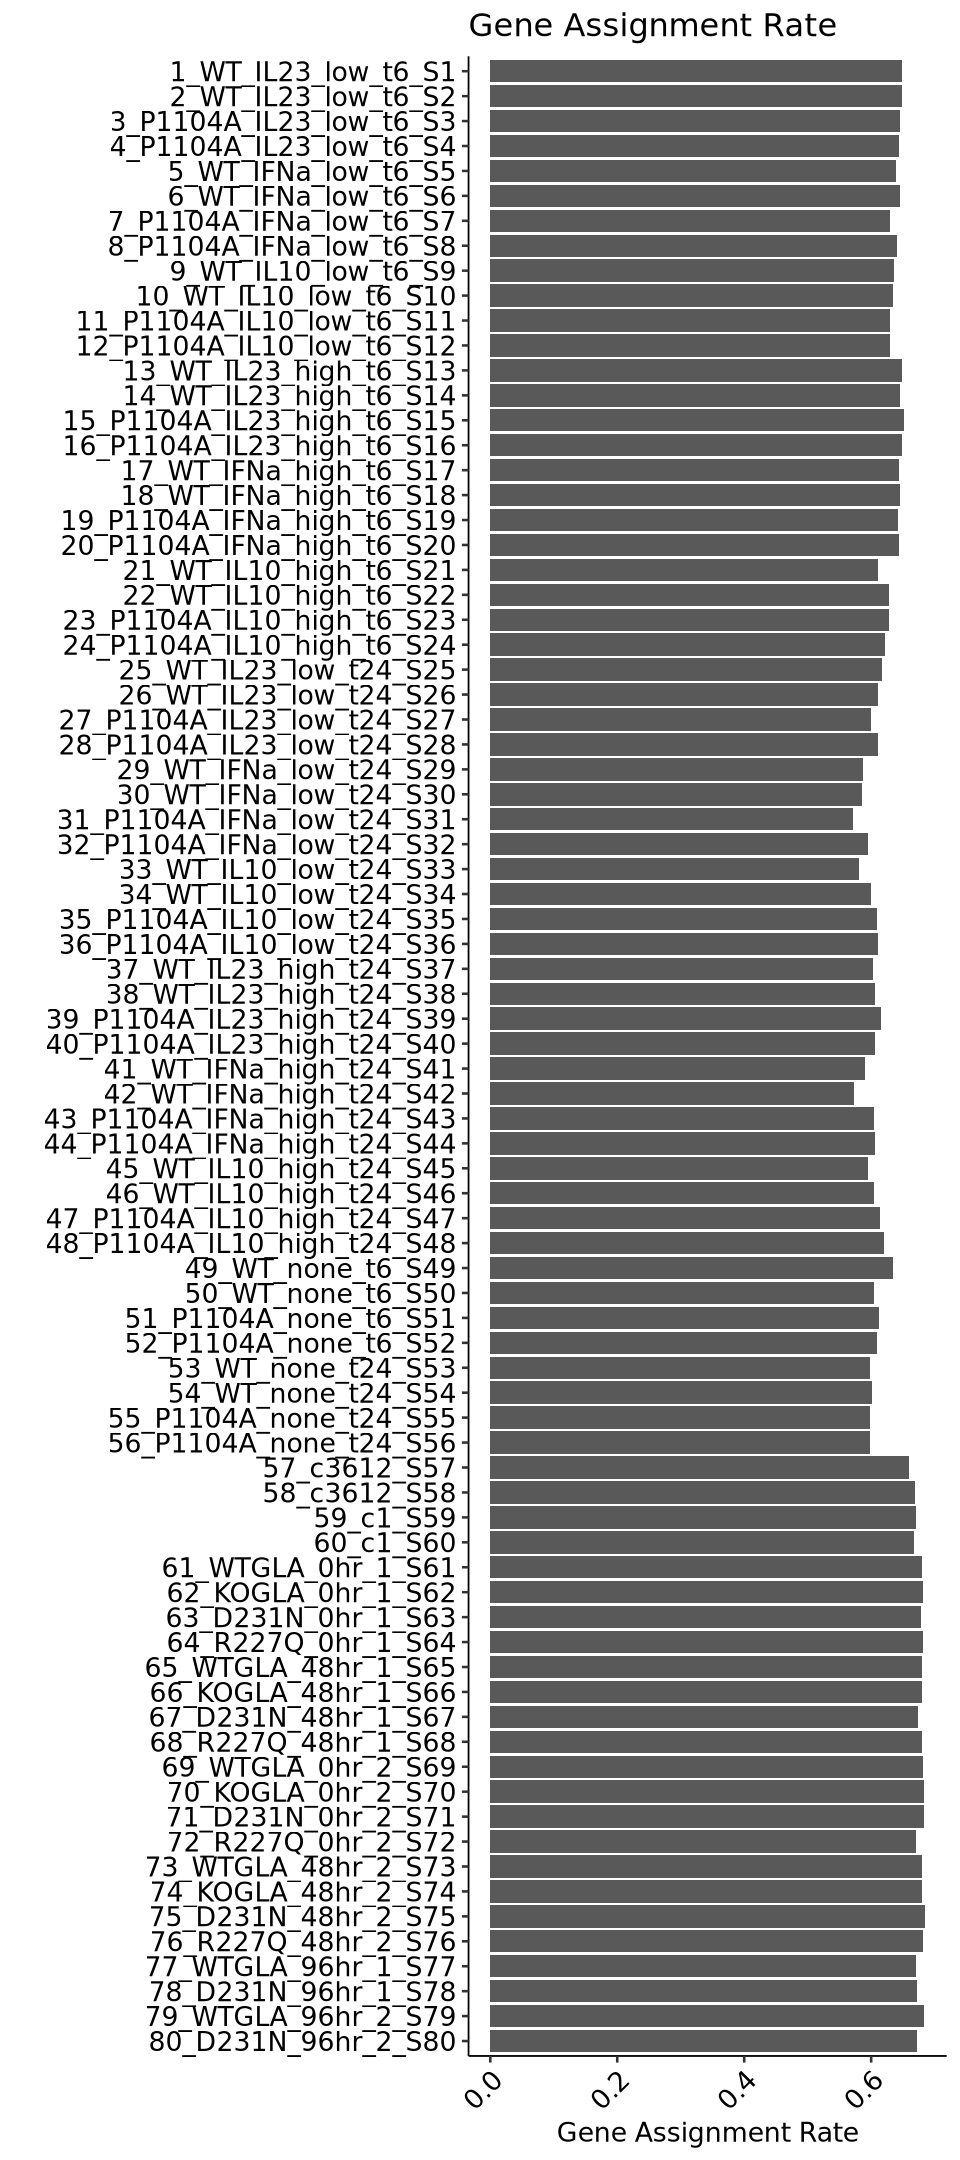

In [6]:
count_summary %>%
    ggplot() +
        geom_bar(aes(x = percent_assigned/100, y = reorder(Sample, -1*as.numeric(id))), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        xlab("Gene Assignment Rate") + ylab("") +
        ggtitle("Gene Assignment Rate")

#### Unsupervised Profiles <a name="part2"></a>

In [4]:
paths <- str_c("../pipeline/diffexp/",
                    alignments$Sample,
                    ".counts.tsv")
names(paths) <- paths
df <- map_dfr(paths,
              ~read_tsv(.x,
                        col_names = NULL,
                        skip = 2,
                        col_select = c(1,7)),
              .id = "sample") %>%
    rename("gene" = "X1",
           "count" = "X7") %>%
    mutate(sample = gsub("../pipeline/diffexp/|.counts.tsv", "", sample))

samp_prop <- read_tsv("../sumstats/RNASEQ/run2/sample-properties-il23.tsv") %>%
    arrange(sample_id) %>%
    mutate(rep = rep(c(1,2), 40),
           covariate = as.factor(str_c(group, "_", cytokine, "_", dosage, "_", time)))
rownames(samp_prop) <- samp_prop$sample_id

df_id <- df %>%
    mutate(id = as.numeric(gsub("_.*", "", sample))) %>%
    select(-sample) %>%
    arrange(id)

Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (1): X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60607 Columns: 2
── Column specification ────────────────────────────────────────────────────────

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


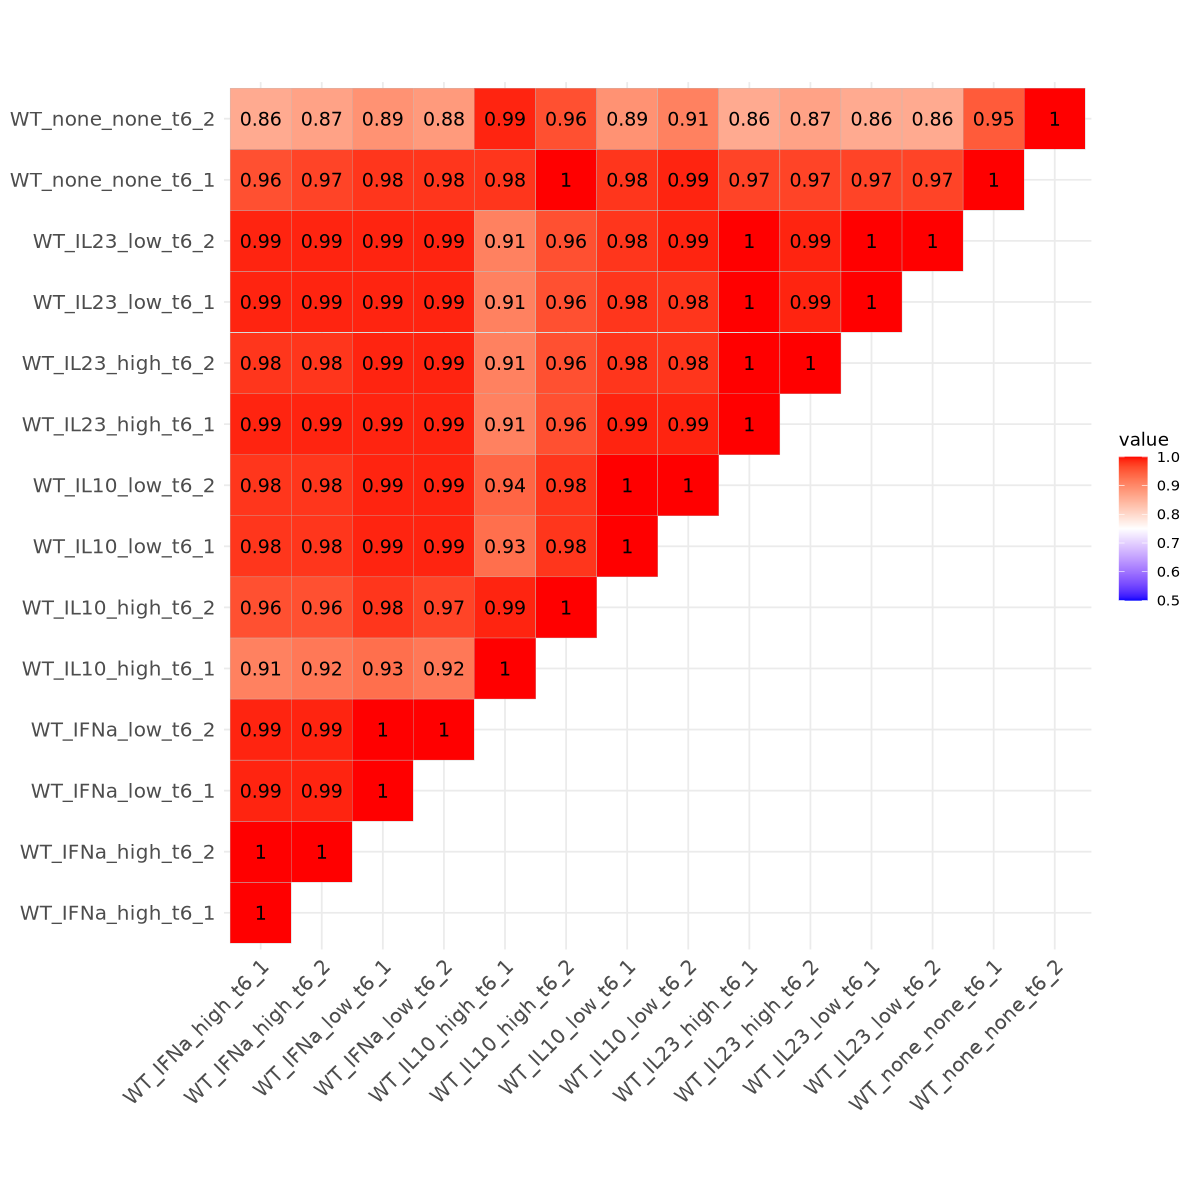

In [5]:
cor_data_wide <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(time == "t6", group == "WT",  count != 0) %>%
    arrange(cytokine, group, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    mutate(count = log2(count)) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

cor_data_wide$v <- rowMeans(as.matrix(cor_data_wide[,-1]), na.rm = TRUE)

cor_data_filt <- cor_data_wide %>%
    arrange(-v) %>%
    head(1000) %>%
    select(-gene, -v)

cor_mat <- cor(cor_data_filt, use = "pairwise.complete.obs")

options(repr.plot.width = 10, repr.plot.height = 10)
ggcorrplot(cor_mat, lab = TRUE, lab_size = 4, hc.order = FALSE, type = "upper", show.diag = TRUE) +
    scale_fill_gradient2(limit = c(0.5,1), low = "blue", high =  "red", mid = "white", midpoint = 0.75)

In [7]:
pca_data <- inner_join(df_id, samp_prop, by = c("id" = "sample_id")) %>%
    filter(!is.na(covariate)) %>%
    arrange(cytokine, group, dosage, rep) %>%
    select(gene, covariate, rep, count) %>%
    mutate(count = log2(count + 1)) %>%
    pivot_wider(names_from = covariate:rep, values_from = count)

pca_data <- t(as.matrix(pca_data[,-1]))

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


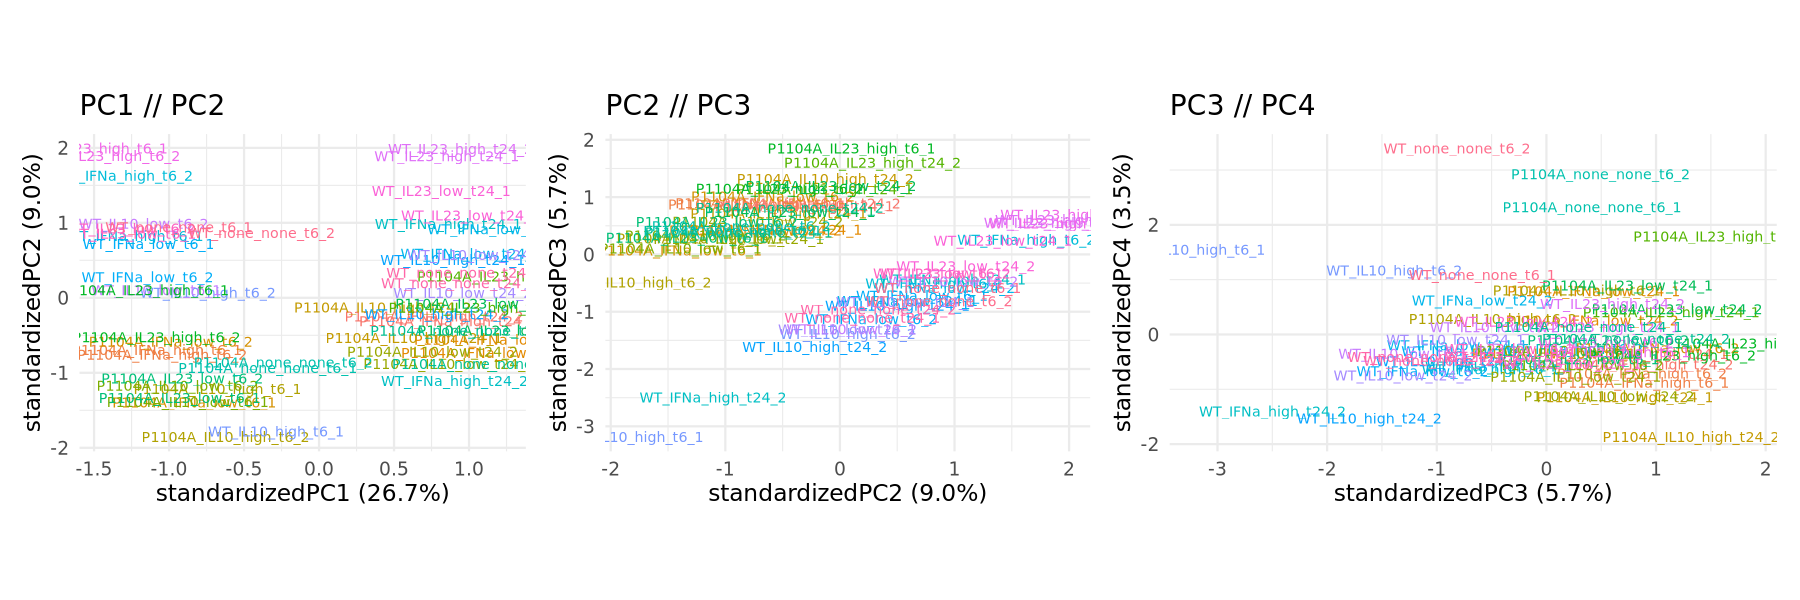

In [19]:
pca1 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 1:2,) +
        ggtitle("PC1 // PC2")

pca2 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 2:3,) +
        ggtitle("PC2 // PC3")

pca3 <- ggbiplot(prcomp(pca_data[,colVars(pca_data) > 0]),labels.size = 3,
         var.axes = FALSE,
         labels = rownames(pca_data),
         groups = gsub("_1|_2", "",  rownames(pca_data)),
         choices = 3:4,) +
        ggtitle("PC3 // PC4")

options(repr.plot.width = 15, repr.plot.height = 5, warn = -1)
pca1 + pca2 + pca3  &
  theme_minimal(base_size = 14) &
  theme(legend.position = "none") &
  coord_equal(ratio = 0.5)

#### Statistical Modeling <a name="part3"></a>

In [11]:
de_data <- df_id %>%
    filter(id %in% 1:56) %>%
    pivot_wider(names_from = id, values_from = count)

de_prop <- samp_prop %>% filter(sample_id %in% 1:56)

# de_prop[21,1] <- 49
# de_prop[49,1] <- 21
# de_prop <- de_prop %>% arrange(sample_id)

rownames(de_prop) <- de_prop$sample_id

Warning message:
“Setting row names on a tibble is deprecated.”


In [15]:
deobj_counts <- DESeqDataSetFromMatrix(countData = de_data %>% select(-gene),
    colData = de_prop,
    design = ~covariate)

deresult <- DESeq(deobj_counts)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [16]:
cov_group <- de_prop %>%
    filter(!grepl("none", covariate)) %>%
    distinct(covariate) %>%
    pull(covariate) %>%
    as.character()

none_group <- gsub("IFNa|IL10|IL23|low|high", "none", cov_group) %>%
    as.character()

plan(multicore, workers = 25)
norm_result <- future_map2(.x = cov_group,
                    .y = none_group,
                    ~results(deresult,
                             contrast = c("covariate", .x, .y),
                             independentFiltering = FALSE))

sumstats <- map2_dfr(norm_result,
                     cov_group,
                     ~bind_cols("gene" = de_data$gene,
                                            as_tibble(.x),
                                            "condition" = .y))

write_tsv(sumstats, "../sumstats/RNASEQ/run2/deseq2-sumstats-vs-none.tsv")

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

In [17]:
sumstats <- read_tsv( "../sumstats/RNASEQ/run2/deseq2-sumstats-vs-none.tsv")
split_sumstats <- sumstats %>%
    mutate(group = case_when(padj == 1 ~ "FDR = 1",
                             padj < 0.01 ~ "FDR < 0.01",
                             TRUE ~ "NS")) %>%
    separate(condition, c("background", "cytokine", "dosage", "time")) %>%
    mutate(time = relevel(as.factor(time), ref = "t6"))

ma_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2(baseMean),
                       y = log2FoldChange,
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

Rows: 1454568 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene, condition
dbl (6): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


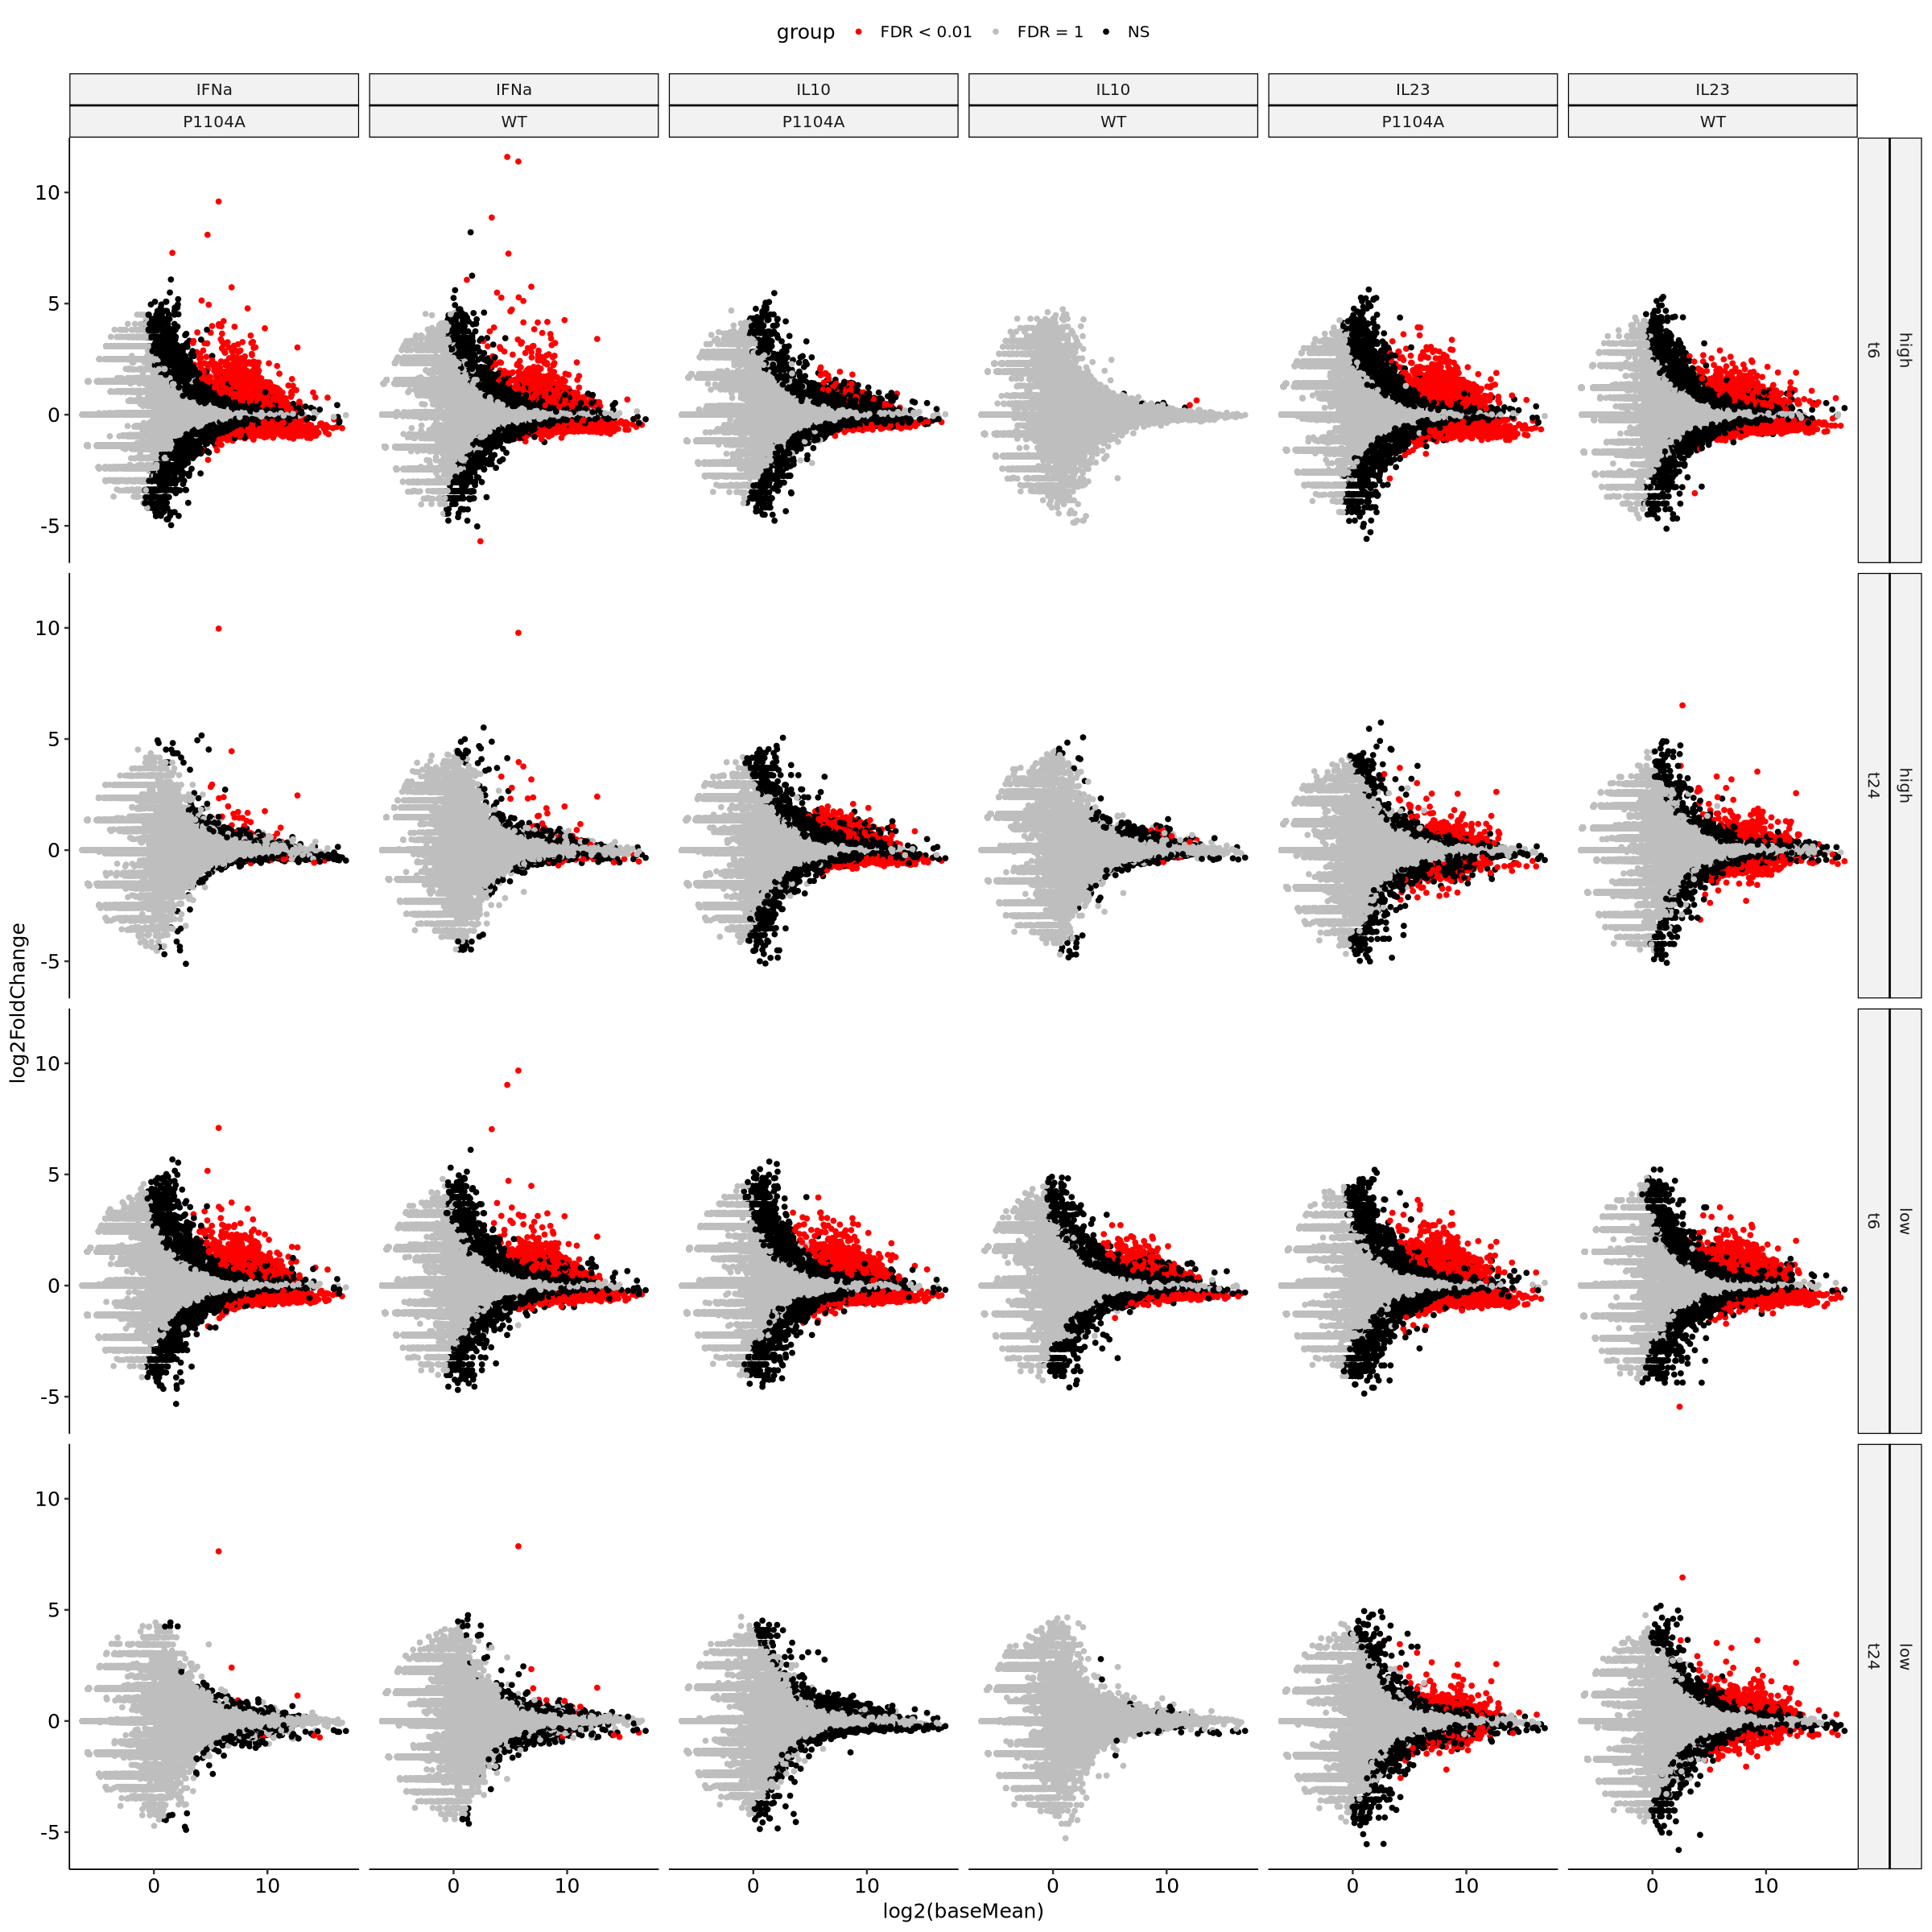

In [18]:
options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
ma_grid

In [133]:
volcano_grid <- split_sumstats %>%
    ggplot() +
        geom_point(aes(x = log2FoldChange,
                       y = -log10(pvalue),
                       color = group)) +
        theme_pubr(base_size = 15) +
        facet_grid(rows = vars(dosage, time),
                   cols = vars(cytokine, background)) +
        scale_color_manual(values = c("FDR = 1" = "gray",
                                      "NS" = "black",
                                      "FDR < 0.01" = "red"))

options(repr.plot.width = 20, repr.plot.height = 20, warn = -1)
volcano_grid

#### Differentially Expressed Genes <a name="part4"></a>

In [143]:
vsd <- assay(vst(deresult, blind = FALSE))
vsd <- cbind(vsd, "row_var" = rowVars(vsd, na.rm = TRUE))

vsd_gene <- bind_cols("gene" = de_data$gene,
                      vsd) %>%
    pivot_longer(names_to = "sample", values_to = "norm_value", `1`:`56`) %>%
    inner_join(de_prop %>% mutate(sample_id = as.character(sample_id)),
               by = c("sample" = "sample_id")) %>%
    arrange(cytokine, group, dosage, time, rep)

var_genes <- vsd_gene %>%
    select(gene, row_var) %>%
    distinct() %>%
    arrange(-row_var) %>%
    head(500) %>%
    pull(gene)

vsd_gene_wide_sig <- vsd_gene %>%
    filter(gene %in% var_genes) %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

vsd_gene_wide_all <- vsd_gene %>%
    mutate(sample_name = str_c(cytokine, " ", dosage, " ", group, " ", time, " ", rep)) %>%
    select(gene, sample_name, norm_value) %>%
    pivot_wider(names_from = sample_name, values_from = norm_value)

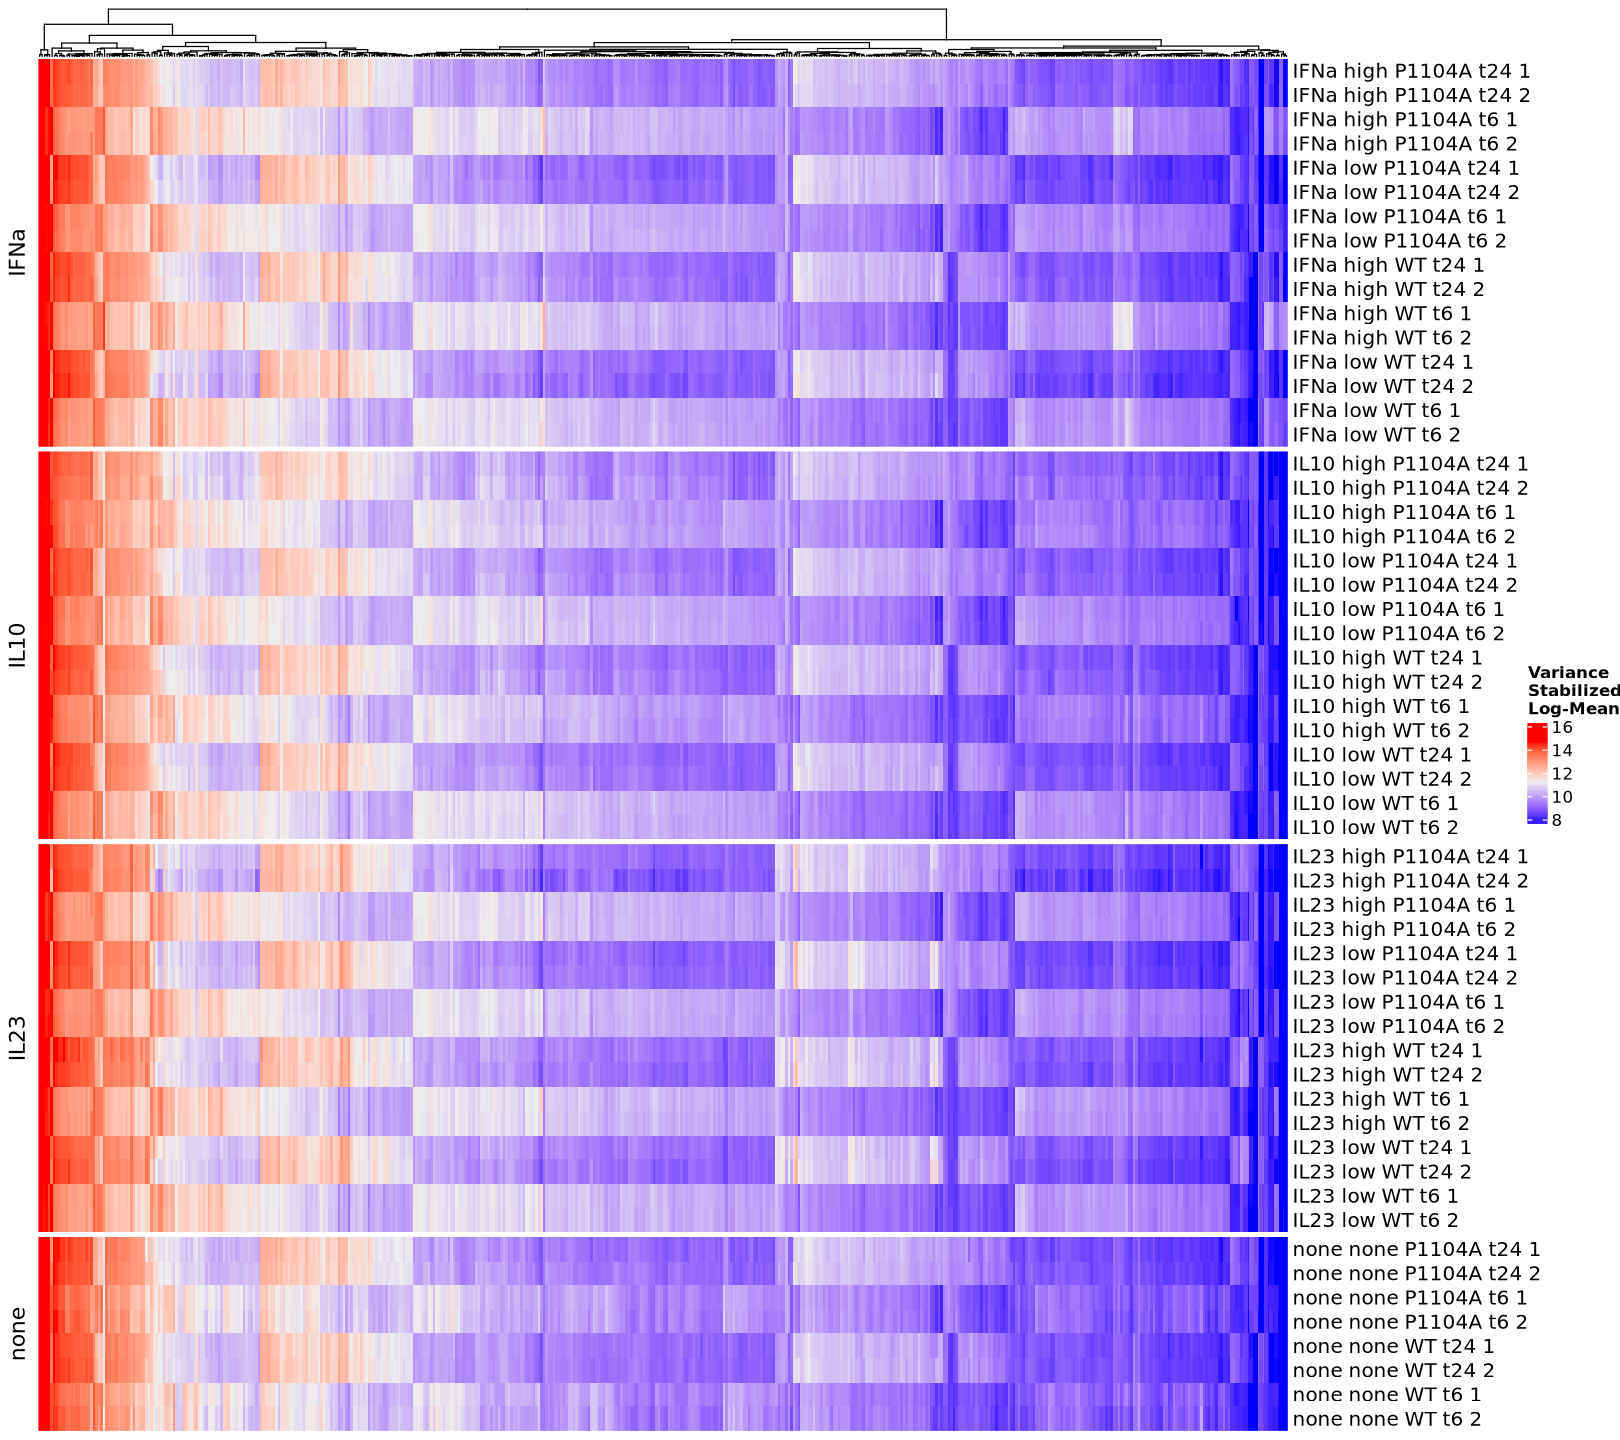

In [144]:
options(repr.plot.width = 13.5, repr.plot.height = 12)
Heatmap(t(as.matrix(vsd_gene_wide_sig[,-1])),
        cluster_columns = TRUE,
        cluster_rows = FALSE,
        row_split = gsub(" .*", "", names(vsd_gene_wide_sig[,-1])),
        use_raster = TRUE,
        raster_by_magick = TRUE,
        name = "Variance\nStabilized\nLog-Mean")

In [149]:
de_genes_sig <- split_sumstats %>%
    filter(log2FoldChange > 1, padj < 0.01, !grepl("ENSG", gene)) %>%
    pull(gene) %>%
    unique()

heat_genes_wide <- vsd_gene_wide_all[vsd_gene_wide_all$gene %in% de_genes_sig,]
heat_data <- t(as.matrix(heat_genes_wide[,-1]))
colnames(heat_data) <- unlist(heat_genes_wide[,1])

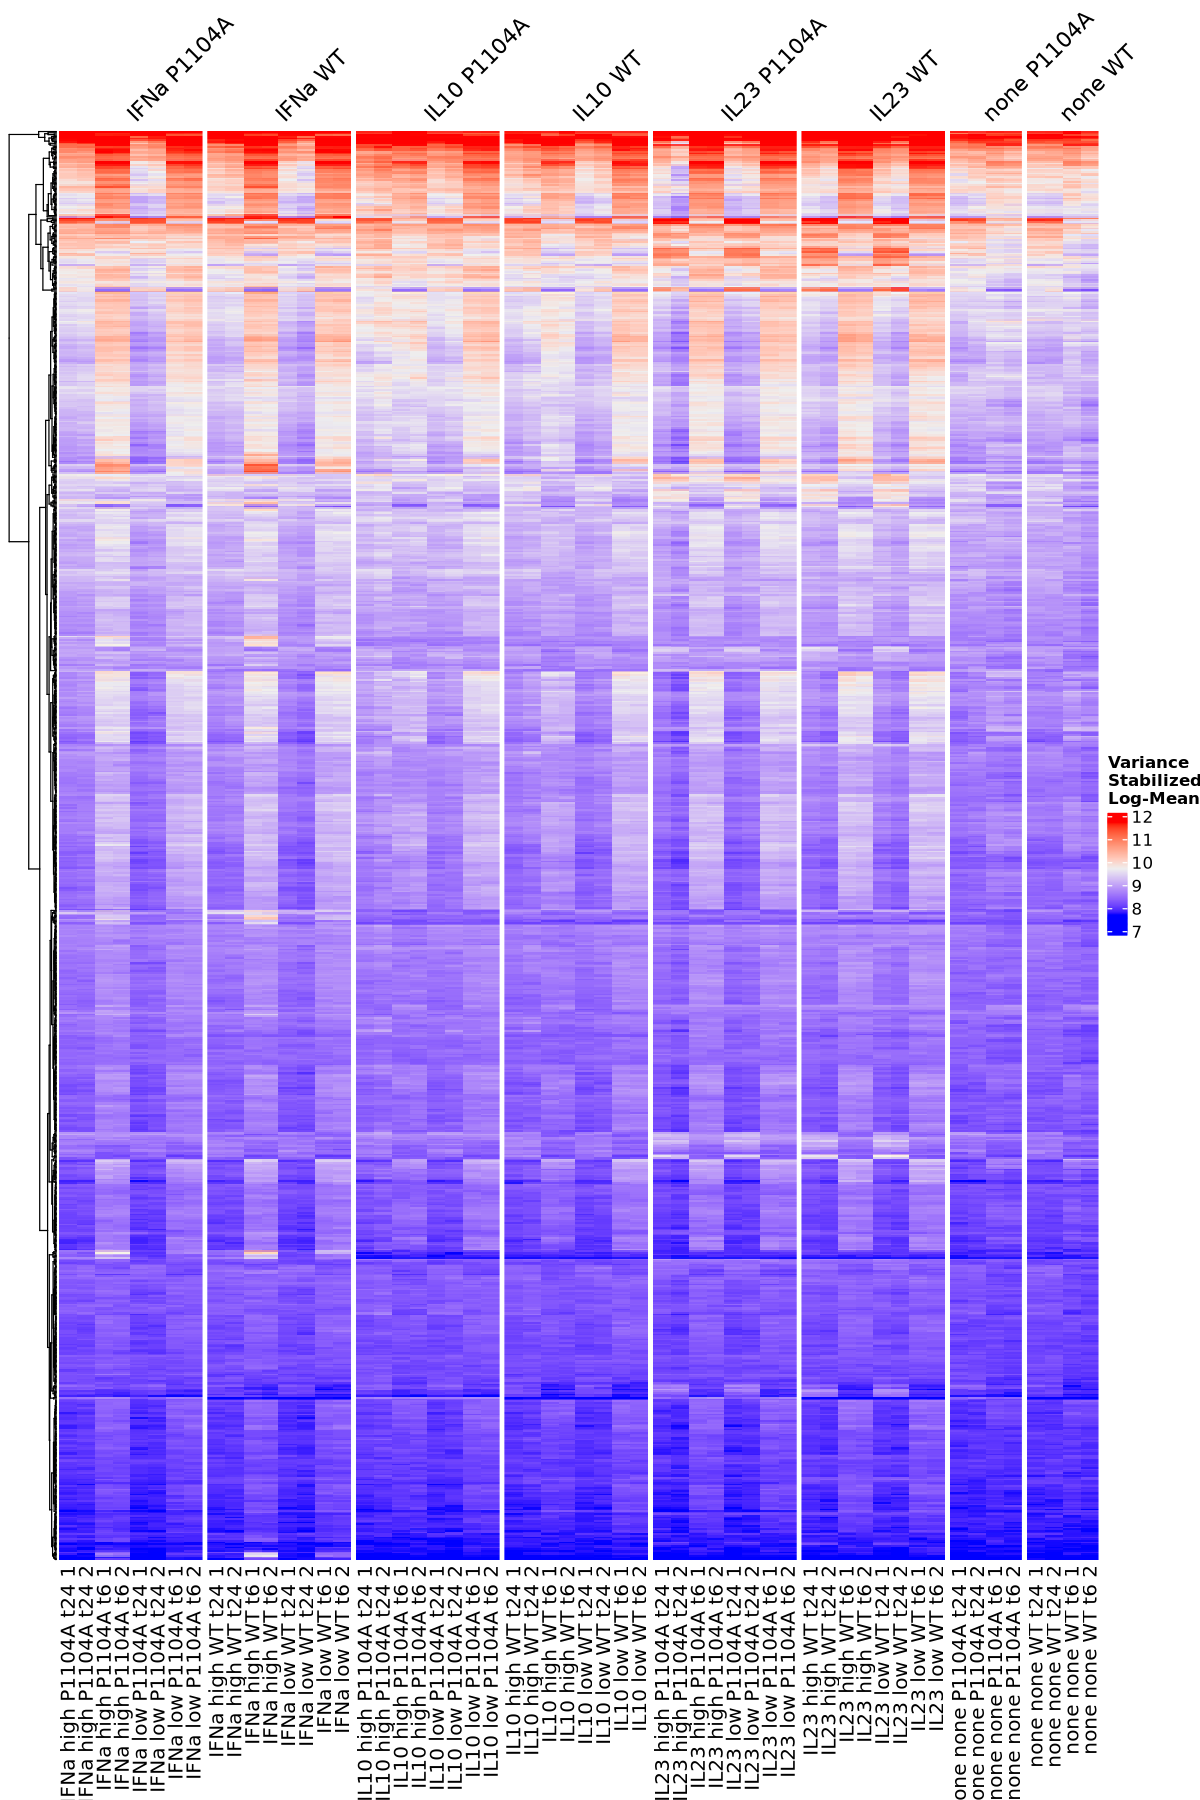

In [150]:
options(repr.plot.width = 10, repr.plot.height = 15)
#pdf("heat-immune-genes.pdf", width = 13.5, height = 25)
Heatmap(t(heat_data),show_row_names = FALSE,
        cluster_columns = FALSE,
        cluster_rows = TRUE,
        column_split = gsub("low |high |t6|t24| 1| 2| none", "", colnames(heat_genes_wide[,-1])),
        use_raster = TRUE,
        column_title_rot = 45,
        name = "Variance\nStabilized\nLog-Mean")
#dev.off()

#### Gene Visualizations <a name="part5"></a>

In [22]:
plot_gene <- function(gene_id) {

    the_plot <- sumstats %>%
        filter(gene == gene_id) %>%
        ggplot() +
            geom_pointrange(aes(x = cytokine,
                                y = log2FoldChange,
                                ymin = log2FoldChange - 2*lfcSE,
                                ymax = log2FoldChange + 2*lfcSE)) +
            theme_pubr(base_size = 16) +
            ggtitle(gene_id) +
            coord_cartesian(ylim = c(-0.5, 3)) +
            geom_hline(yintercept = 0)

    return(the_plot)
    
}


stat1 <- plot_gene("STAT1")
stat2 <- plot_gene("STAT2")
stat3 <- plot_gene("STAT3")

jak1 <- plot_gene("JAK1")
jak2 <- plot_gene("JAK2")
jak3 <- plot_gene("JAK3")

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)
stat1 + stat2 + stat3
jak1 + jak2 + jak3

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 6)
vsd_gene %>%
    filter(gene == "ISG15") %>%
    mutate(time = relevel(as.factor(time), ref = "t6"),
           dosage = relevel(as.factor(dosage), ref = "low")) %>%
    ggplot() +
        geom_point(aes(x = time,
                       y = norm_value,
                       color = group), position = position_jitter(width = 0.1),
                   size = 3) +
        facet_wrap(~cytokine + dosage, nrow = 1) +
        theme_pubr(base_size = 16) +
        scale_color_manual(name = "",
                           values = c("WT" = "black",
                                      "P1104A" = "red")) +
        ggtitle("ISG15")